# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

## Загрузка датасета

In [6]:
# Для локального запуска загрузите kaggle.json в ~/.kaggle/kaggle.json и дайте права:
# !chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Для запуска в colab

# from google.colab import files
# uploaded = files.upload('/root/.kaggle')
# !chmod 600 /root/.kaggle/kaggle.json

In [8]:
# 1. Скачиваем данные
!kaggle competitions download -p ../data -c m5-forecasting-accuracy --force

  0%|                                               | 0.00/45.8M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:00<00:00, 2.24GB/s]


In [9]:
# 2. Разархивируем
import zipfile
from pathlib import Path

extract_dir = Path('../data')
zip_path = extract_dir / 'm5-forecasting-accuracy.zip'

# Убедимся, что папка существует
extract_dir.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'✅ Архив распакован в: {extract_dir}')

✅ Архив распакован в: ../data


In [10]:
# ---------- ШАГ 1: Загрузка и оптимизация ---------- #
import pandas as pd

# Функция для сжатия памяти
def reduce_mem_usage(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_integer_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'  ▸ memory {start_mem:,.1f} → {end_mem:,.1f} MiB '
              f'({100 * (start_mem - end_mem) / start_mem:0.1f}% экономия)')
    return df

# ---------- Чтение файлов с нужными типами ---------- #
print('Читаем sales_train_validation.csv …')
dtype_sales = {col: 'category' for col in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']}
sales = pd.read_csv(extract_dir / 'sales_train_validation.csv', dtype=dtype_sales)

print('Читаем calendar.csv …')
calendar = pd.read_csv(
    extract_dir / 'calendar.csv',
    parse_dates=['date'],
    dtype={
        'weekday': 'category',
        'wm_yr_wk': 'int16',
        'event_name_1': 'category',
        'event_type_1': 'category',
        'event_name_2': 'category',
        'event_type_2': 'category',
        'snap_CA': 'int8',
        'snap_TX': 'int8',
        'snap_WI': 'int8'
    }
)

print('Читаем sell_prices.csv …')
prices = pd.read_csv(
    extract_dir / 'sell_prices.csv',
    dtype={
        'store_id': 'category',
        'item_id': 'category',
        'wm_yr_wk': 'int16',
        'sell_price': 'float32'
    }
)

# ---------- Оптимизация памяти ---------- #
print('\nОптимизируем память:')
sales = reduce_mem_usage(sales)
calendar = reduce_mem_usage(calendar)
prices = reduce_mem_usage(prices)

# ---------- Проверим размерности ---------- #
print('\nРазмеры таблиц:')
for name, df in [('sales', sales), ('calendar', calendar), ('prices', prices)]:
    print(f'  {name:<8}: {df.shape}')

sales.head()


Читаем sales_train_validation.csv …
Читаем calendar.csv …
Читаем sell_prices.csv …

Оптимизируем память:
  ▸ memory 448.7 → 96.8 MiB (78.4% экономия)
  ▸ memory 0.2 → 0.2 MiB (-15.8% экономия)
  ▸ memory 59.0 → 59.0 MiB (0.0% экономия)

Размеры таблиц:
  sales   : (30490, 1919)
  calendar: (1969, 14)
  prices  : (6841121, 4)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [11]:
# ---------- ШАГ 2: Преобразование в длинный формат ---------- #

# Преобразуем только нужные колонки
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales_long = pd.melt(
    sales,
    id_vars=id_cols,
    var_name='d',
    value_name='sales'
)

# Проверим результат
print("Преобразованный формат (long):", sales_long.shape)
display(sales_long.head())

Преобразованный формат (long): (58327370, 8)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [12]:
# ---------- ШАГ 3: Объединение таблиц ---------- #

# Объединяем с календарём по "d"
sales_long = sales_long.merge(calendar, how='left', on='d')

# Объединяем с ценами по "store_id", "item_id", "wm_yr_wk"
sales_long = sales_long.merge(prices, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])

# Проверим итоговую структуру
print("Объединённая таблица:", sales_long.shape)
display(sales_long[['date', 'item_id', 'store_id', 'sales', 'sell_price']].head())

Объединённая таблица: (58327370, 22)


,date,item_id,store_id,sales,sell_price
0,2011-01-29,HOBBIES_1_001,CA_1,0,NaN
1,2011-01-29,HOBBIES_1_002,CA_1,0,NaN
2,2011-01-29,HOBBIES_1_003,CA_1,0,NaN
3,2011-01-29,HOBBIES_1_004,CA_1,0,NaN
4,2011-01-29,HOBBIES_1_005,CA_1,0,NaN


In [13]:
# ---------- ШАГ 4: Подготовка обучающего датасета ---------- #

# Удалим строки без информации о цене
sales_train = sales_long.dropna(subset=['sell_price']).copy()

# Проверим результат
print("Форма после очистки:", sales_train.shape)
print(f"  ▸ Уникальных товаров: {sales_train['item_id'].nunique()}")
print(f"  ▸ Уникальных дней: {sales_train['date'].nunique()}")
print(f"  ▸ Доля нулевых продаж: {(sales_train['sales'] == 0).mean():.2%}")

# Быстрый просмотр
display(sales_train[['date', 'item_id', 'store_id', 'sales', 'sell_price']].sample(5))

Форма после очистки: (46027957, 22)
  ▸ Уникальных товаров: 3049
  ▸ Уникальных дней: 1913
  ▸ Доля нулевых продаж: 59.70%


,date,item_id,store_id,sales,sell_price
29249230,2013-09-14,HOBBIES_1_178,CA_4,22,0.46
20647210,2012-12-06,FOODS_3_207,CA_2,0,2.18
11337749,2012-02-04,HOUSEHOLD_2_472,WI_2,0,6.27
27554047,2013-07-20,HOBBIES_1_242,WI_1,3,2.78
14147941,2012-05-07,HOUSEHOLD_1_017,CA_1,0,4.97


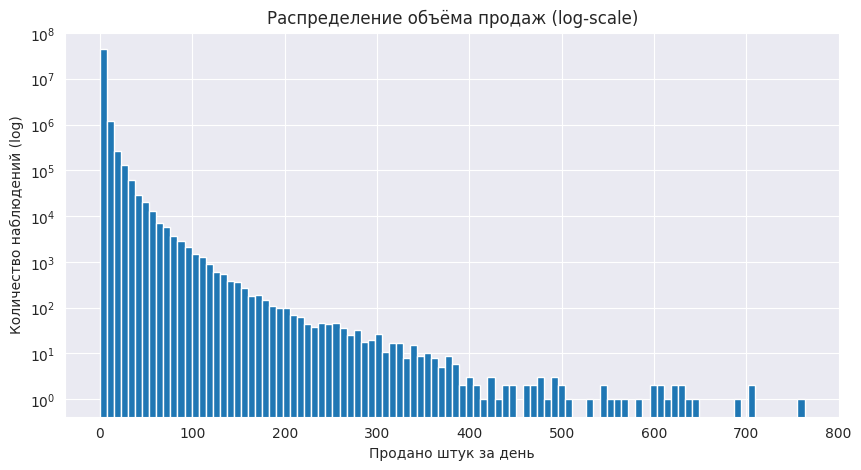

count    4.602796e+07
mean     1.427294e+00
std      4.310440e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.630000e+02
Name: sales, dtype: float64


In [14]:
import matplotlib.pyplot as plt

# ---------- ШАГ 5: Распределение объёма продаж ---------- #
plt.figure(figsize=(10, 5))
sales_train['sales'].hist(bins=100, log=True)
plt.title('Распределение объёма продаж (log-scale)')
plt.xlabel('Продано штук за день')
plt.ylabel('Количество наблюдений (log)')
plt.grid(True)
plt.show()

# Также выведем базовую статистику
print(sales_train['sales'].describe())

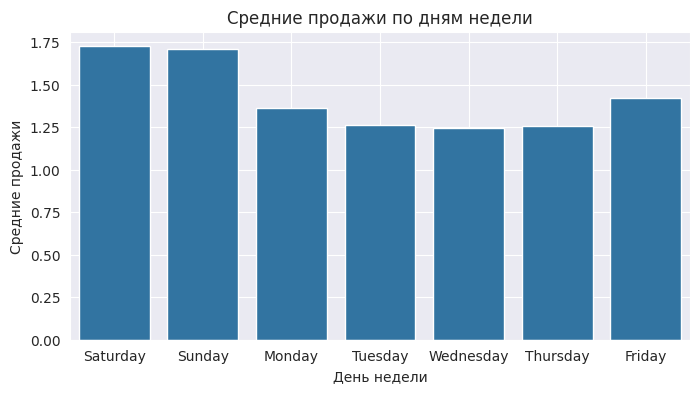

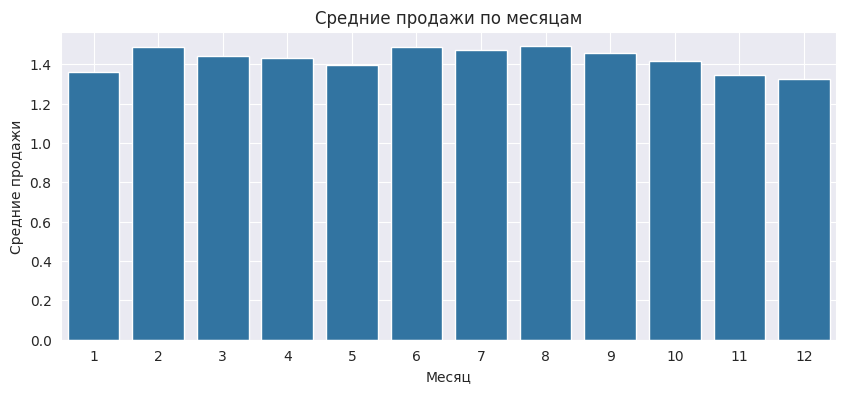

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- ШАГ 6: Сезонность продаж ----------
# Цель: исследовать влияние календарных признаков (день недели, месяц) на объём продаж.
# Это помогает выявить сезонные и еженедельные паттерны в поведении покупателей.

# Убедимся, что нужные колонки имеют корректные типы
sales_train['weekday'] = sales_train['weekday'].astype(str)
sales_train['month'] = sales_train['date'].dt.month
sales_train['year'] = sales_train['date'].dt.year

# --- Средние продажи по дням недели ---
plt.figure(figsize=(8, 4))
sns.barplot(
    data=sales_train,
    x='weekday',
    y='sales',
    estimator='mean',
    errorbar=None,
    order=['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
)
plt.title('Средние продажи по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средние продажи')
plt.grid(True)
plt.show()

# --- Средние продажи по месяцам ---
plt.figure(figsize=(10, 4))
sns.barplot(
    data=sales_train,
    x='month',
    y='sales',
    estimator='mean',
    errorbar=None
)
plt.title('Средние продажи по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средние продажи')
plt.grid(True)
plt.show()

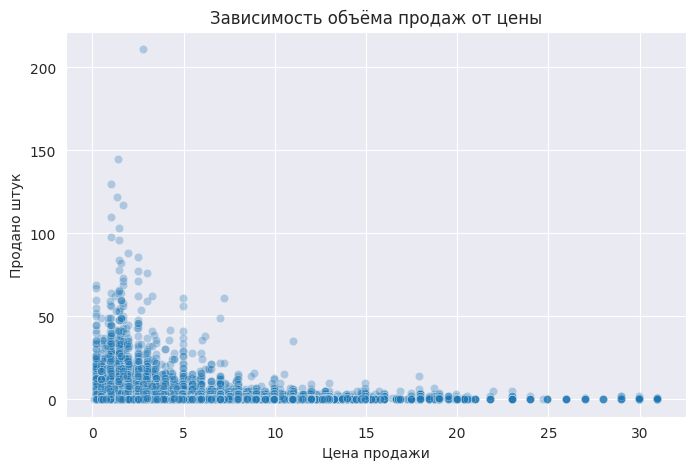

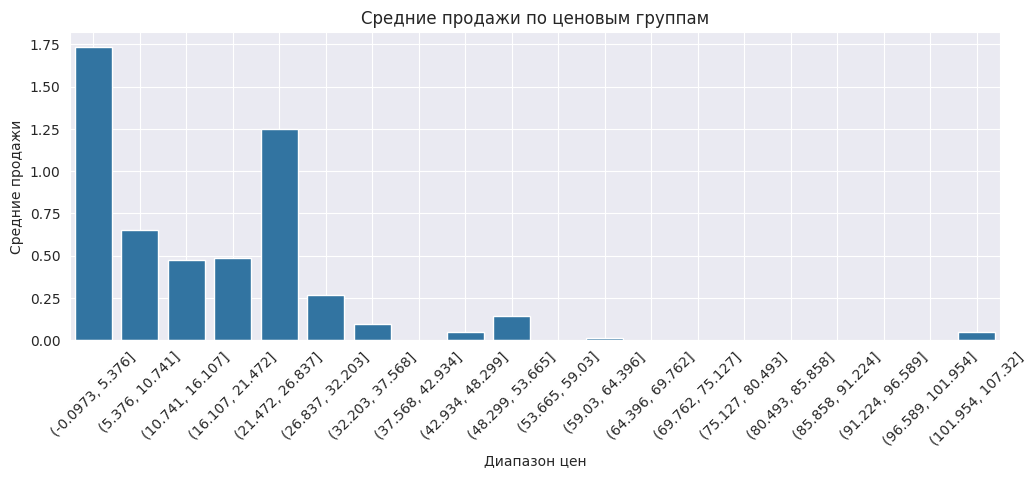

In [16]:
# ---------- ШАГ 7: Влияние цены на продажи ----------
# Цель: проанализировать зависимость между sell_price и sales — есть ли обратная связь?

import seaborn as sns
import matplotlib.pyplot as plt

# --- Scatter plot (тонкий, но "шумный") ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=sales_train.sample(50000), x='sell_price', y='sales', alpha=0.3)
plt.title('Зависимость объёма продаж от цены')
plt.xlabel('Цена продажи')
plt.ylabel('Продано штук')
plt.grid(True)
plt.show()

# --- Средние продажи по ценовым корзинам ---
# Разбиваем цены на интервалы
sales_train['price_bin'] = pd.cut(sales_train['sell_price'], bins=20)

plt.figure(figsize=(12, 4))
sns.barplot(data=sales_train, x='price_bin', y='sales', estimator='mean', errorbar=None)
plt.title('Средние продажи по ценовым группам')
plt.xlabel('Диапазон цен')
plt.ylabel('Средние продажи')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

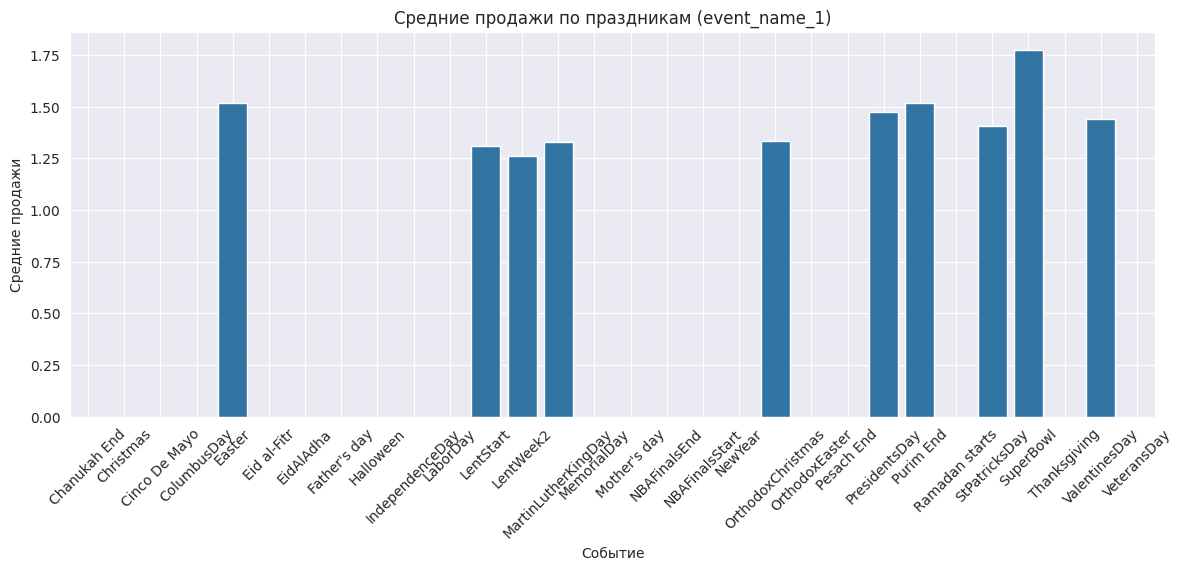

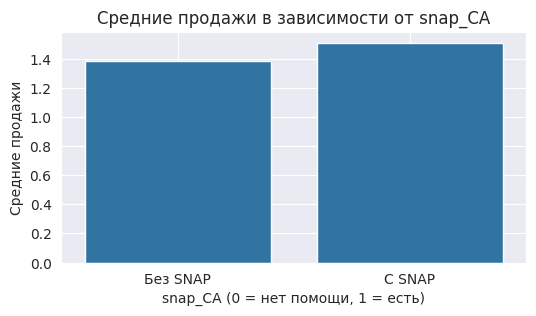

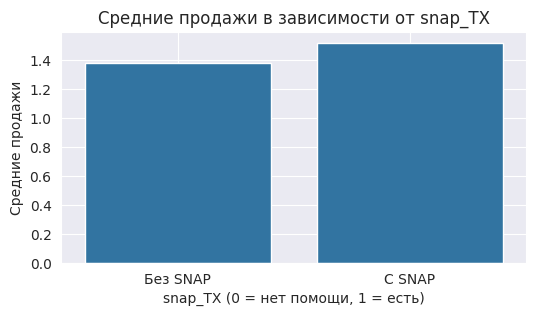

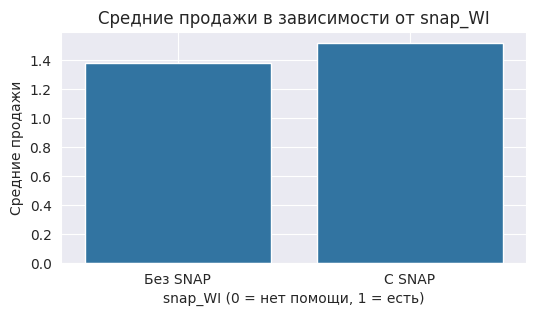

In [17]:
# ---------- ШАГ 8: Влияние праздников и событий ----------
# Цель: проанализировать, как продажи изменяются во время праздников и при наличии SNAP-дней

import seaborn as sns
import matplotlib.pyplot as plt

# --- Средние продажи по событиям ---
plt.figure(figsize=(14, 5))
top_events = sales_train['event_name_1'].value_counts().index[:10]
sns.barplot(
    data=sales_train[sales_train['event_name_1'].isin(top_events)],
    x='event_name_1',
    y='sales',
    estimator='mean',
    errorbar=None
)
plt.title('Средние продажи по праздникам (event_name_1)')
plt.xlabel('Событие')
plt.ylabel('Средние продажи')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# --- Влияние SNAP-дней (продуктовая помощь в штатах США) ---
for snap_col in ['snap_CA', 'snap_TX', 'snap_WI']:
    plt.figure(figsize=(6, 3))
    sns.barplot(data=sales_train, x=snap_col, y='sales', estimator='mean', errorbar=None)
    plt.title(f'Средние продажи в зависимости от {snap_col}')
    plt.xlabel(f'{snap_col} (0 = нет помощи, 1 = есть)')
    plt.ylabel('Средние продажи')
    plt.xticks([0, 1], ['Без SNAP', 'С SNAP'])
    plt.grid(True)
    plt.show()

In [18]:
# Какие уникальные значения есть в event_name_2
print("Всего уникальных значений в event_name_2:", sales_train['event_name_2'].nunique())
print("\nТоп значений:")
print(sales_train['event_name_2'].value_counts().head(10))

Всего уникальных значений в event_name_2: 4

Топ значений:
event_name_2
Father's day      28295
OrthodoxEaster    27699
Cinco De Mayo     23886
Easter            14603
Name: count, dtype: int64


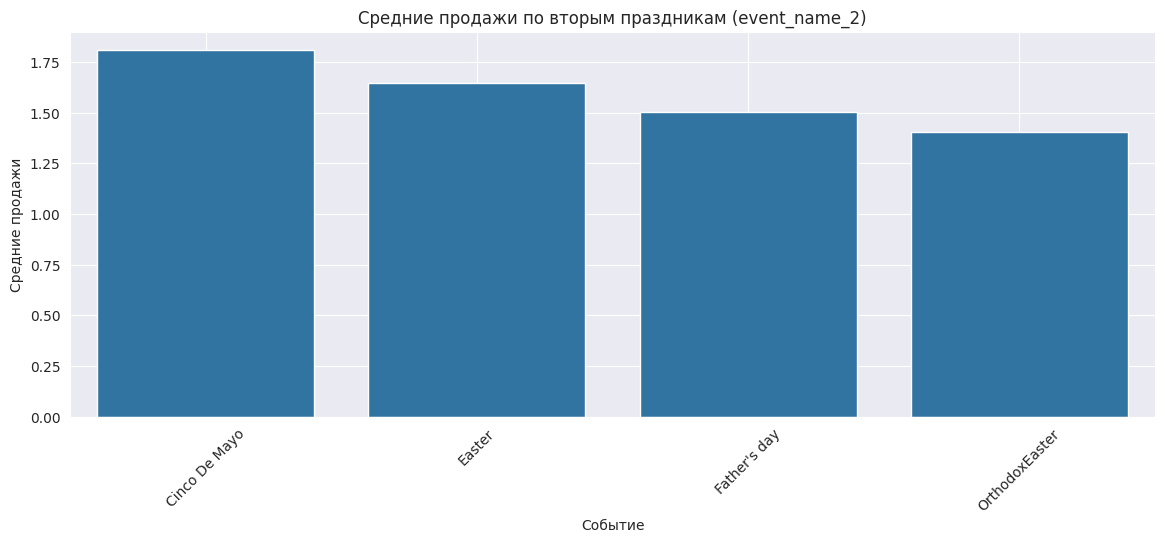

In [19]:
# Влияние вторичных событий (если есть смысл)
top_events_2 = sales_train['event_name_2'].value_counts().index[:10]

plt.figure(figsize=(14, 5))
sns.barplot(
    data=sales_train[sales_train['event_name_2'].isin(top_events_2)],
    x='event_name_2',
    y='sales',
    estimator='mean',
    errorbar=None
)
plt.title('Средние продажи по вторым праздникам (event_name_2)')
plt.xlabel('Событие')
plt.ylabel('Средние продажи')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [20]:
# ---------- ШАГ 9: Генерация временных признаков ---------- #
# Цель: извлечь из даты и категориальных данных признаки для обучения моделей

import numpy as np

# Временные признаки
sales_train['day'] = sales_train['date'].dt.day
sales_train['weekday_num'] = sales_train['date'].dt.weekday  # Monday = 0
sales_train['is_weekend'] = sales_train['weekday'].isin(['Saturday', 'Sunday']).astype(int)
sales_train['week'] = sales_train['date'].dt.isocalendar().week.astype('int16')
sales_train['quarter'] = sales_train['date'].dt.quarter

# Флаг наличия события
sales_train['is_event'] = sales_train['event_name_1'].notna().astype(int) | sales_train['event_name_2'].notna().astype(int)

# Категориальные фичи (например, item_id и dept_id — оставим, они уже категориальные)
# Преобразование цены
sales_train['log_price'] = np.log1p(sales_train['sell_price'])

# Проверим результат
print("Признаки добавлены. Размер:", sales_train.shape)
display(sales_train[['date', 'sales', 'sell_price', 'log_price', 'weekday', 'is_weekend', 'is_event']].sample(5))


Признаки добавлены. Размер: (46027957, 30)


,date,sales,sell_price,log_price,weekday,is_weekend,is_event
10034489,2011-12-24,1,5.77,1.912501,Saturday,1,0
10958549,2012-01-23,0,0.77,0.570980,Monday,0,0
46782735,2015-04-12,1,10.97,2.482404,Sunday,1,1
9108352,2011-11-23,0,3.78,1.564440,Wednesday,0,0
14989927,2012-06-03,0,9.98,2.396075,Sunday,1,0


In [21]:
# ---------- ШАГ 10: Лаги и скользящие статистики ---------- #
# Цель: добавить признаки с задержками и средними значениями по временным окнам
# Устраняем предупреждения о параметре observed

# Группировка по уникальному товару в магазине
group_cols = ['id']

# Добавляем лаги (на 1, 7, 14 дней)
for lag in [1, 7, 14]:
    sales_train[f'lag_{lag}'] = sales_train.groupby(group_cols, observed=True)['sales'].shift(lag)

# Добавляем скользящие средние (за 7, 14, 28 дней)
for window in [7, 14, 28]:
    sales_train[f'rolling_mean_{window}'] = (
        sales_train.groupby(group_cols, observed=True)['sales']
        .transform(lambda x: x.shift(1).rolling(window).mean())
    )

# Проверка результата
print("Признаки лагов и скользящих средних добавлены:")
display(sales_train[[f'lag_{l}' for l in [1, 7, 14]] + [f'rolling_mean_{w}' for w in [7, 14, 28]]].dropna().sample(5))

Признаки лагов и скользящих средних добавлены:


,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,rolling_mean_28
37505660,1.0,0.0,0.0,0.142857,0.071429,0.035714
50555593,0.0,0.0,0.0,0.142857,0.214286,0.321429
33715337,6.0,5.0,2.0,3.000000,2.285714,2.892857
17393991,1.0,3.0,0.0,3.142857,3.357143,3.071429
34316338,2.0,0.0,1.0,1.857143,2.071429,1.392857


In [22]:
# ---------- ШАГ 11.1: Агрегаты по группам ---------- #
# Цель: добавить средние продажи по item, dept, store, cat

sales_train['item_sales_mean']  = sales_train.groupby('item_id', observed=True)['sales'].transform('mean')
sales_train['dept_sales_mean']  = sales_train.groupby('dept_id', observed=True)['sales'].transform('mean')
sales_train['store_sales_mean'] = sales_train.groupby('store_id', observed=True)['sales'].transform('mean')
sales_train['cat_sales_mean']   = sales_train.groupby('cat_id', observed=True)['sales'].transform('mean')

print("Агрегаты по группам добавлены.")
display(sales_train[['item_id', 'item_sales_mean', 'dept_sales_mean', 'store_sales_mean']].sample(5))

Агрегаты по группам добавлены.


,item_id,item_sales_mean,dept_sales_mean,store_sales_mean
15880778,HOUSEHOLD_2_491,0.295127,0.363798,1.434710
41904931,FOODS_3_300,2.877900,2.622312,0.898513
55855196,HOUSEHOLD_1_001,0.302070,1.474888,1.371503
7013867,HOUSEHOLD_2_071,0.347087,0.363798,1.636910
44862162,FOODS_2_399,1.280630,1.382125,0.898513


In [23]:
# ---------- ШАГ 11.2: Ценовая динамика ---------- #
# Цель: понять как цена менялась во времени

# Процент изменения цены
sales_train['price_change'] = (
    sales_train.groupby('id', observed=True)['sell_price'].transform(lambda x: x.pct_change())
)

# Минимум и максимум
sales_train['price_min'] = sales_train.groupby('id', observed=True)['sell_price'].transform('min')
sales_train['price_max'] = sales_train.groupby('id', observed=True)['sell_price'].transform('max')

# Отклонения от них
sales_train['price_rel_min'] = sales_train['sell_price'] / sales_train['price_min']
sales_train['price_rel_max'] = sales_train['sell_price'] / sales_train['price_max']

print("Ценовая динамика добавлена.")
display(sales_train[['sell_price', 'price_change', 'price_rel_min', 'price_rel_max']].dropna().sample(5))


Ценовая динамика добавлена.


,sell_price,price_change,price_rel_min,price_rel_max
29514671,14.94,0.0,1.088921,1.000000
52304394,0.94,0.0,1.620690,0.959184
25852573,3.98,0.0,1.000000,1.000000
43898192,1.78,0.0,1.338346,1.000000
19220239,3.96,0.0,1.084931,1.000000


In [24]:
# ---------- ШАГ 11.3: Активность товара ---------- #
# Цель: сколько дней подряд товар продавался за последние N дней

for window in [7, 14, 30]:
    sales_train[f'active_days_{window}'] = (
        sales_train.groupby('id', observed=True)['sales']
        .transform(lambda x: x.shift(1).rolling(window).apply(lambda r: (r > 0).sum(), raw=True))
    )

print("Фичи активности добавлены.")
display(sales_train[[f'active_days_{w}' for w in [7, 14, 30]]].dropna().sample(5))


Фичи активности добавлены.


,active_days_7,active_days_14,active_days_30
32688820,2.0,2.0,2.0
29424266,3.0,5.0,5.0
51984666,0.0,0.0,0.0
54347475,0.0,0.0,0.0
7373953,3.0,7.0,14.0


In [25]:
# ---------- ШАГ 11.4: Лаг цены и флаг скидки ---------- #
# Цель: флаг изменений цены и отклонение от средней

# Лаг цены
sales_train['price_lag_1'] = sales_train.groupby('id', observed=True)['sell_price'].shift(1)

# Флаг скидки (если цена ниже скользящей средней за 28 дней)
sales_train['is_discounted'] = (
    (sales_train['sell_price'] < sales_train['rolling_mean_28']).astype(int)
)

print("Лаг цены и флаг скидки добавлены.")
display(sales_train[['sell_price', 'price_lag_1', 'is_discounted']].dropna().sample(5))


Лаг цены и флаг скидки добавлены.


,sell_price,price_lag_1,is_discounted
48327924,6.97,6.97,0
48654837,3.28,3.28,0
52654810,0.88,0.88,1
55150786,0.23,0.23,1
46265291,2.48,2.48,0


In [28]:
# ---------- ШАГ 12: Сохранение подготовленных данных ---------- #
# Цель: сохранить итоговый датасет с готовыми признаками в быстром формате .feather
# Он будет использоваться для обучения моделей во втором ноутбуке

# Финальный датасет без пропусков
train_data = sales_train.dropna().reset_index(drop=True)

# Путь к файлу
output_path = extract_dir / "train_data.feather"

# Сохраняем
train_data.to_feather(output_path)

print("✅ Данные успешно сохранены в:", output_path)
print("Финальный размер:", train_data.shape)

✅ Данные успешно сохранены в: ../data/train_data.feather
Финальный размер: (92313, 50)
